In [1]:
%run imports.ipynb

In [2]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.32.227.101:33501 Dashboard: /user/carlo%20mariade%20marco1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
allel.GenotypeDaskArray(callset_phase2['3L']['calldata/GT'])

<GenotypeDaskArray shape=(10640388, 1142, 2) dtype=int8>

In [5]:
allel.GenotypeDaskArray(callset_biallel['3L']['calldata/GT'])

<GenotypeDaskArray shape=(7897666, 1142, 2) dtype=int8>

-------------------------

In [59]:
call = callset_phase2
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('samples.meta.txt', delimiter='\t')

In [7]:
hka_coluzzii = pd.read_csv('data/coluzzii_hka_summary.tab_beta.tab', delimiter='\t')
hka_coluzzii

,chrom,gene,segreg_c,pri_der_fix_c,score_c
0,3L,AGAP010742,1949,1,1.366328
1,3L,AGAP010310,118,3,2.876340
2,3L,AGAP010788,1306,2,0.468704
3,3L,AGAP010313,112,5,9.849562
4,3L,AGAP010781,487,1,0.053944
...,...,...,...,...,...
194,X,AGAP000958,413,7,4.504115
195,X,AGAP001029,44,4,15.475486
196,X,AGAP013136,47,1,0.383713
197,X,AGAP000954,324,1,0.139991


In [45]:
(hka_coluzzii)

,chrom,gene,segreg_c,pri_der_fix_c,score_c
0,3L,AGAP010742,1949,1,1.366328
1,3L,AGAP010310,118,3,2.876340
2,3L,AGAP010788,1306,2,0.468704
3,3L,AGAP010313,112,5,9.849562
4,3L,AGAP010781,487,1,0.053944
...,...,...,...,...,...
194,X,AGAP000958,413,7,4.504115
195,X,AGAP001029,44,4,15.475486
196,X,AGAP013136,47,1,0.383713
197,X,AGAP000954,324,1,0.139991


In [46]:
homogen_test = pd.read_csv('data/homogeneity_summary_beta.tab', sep = '\t')
(homogen_test)

,chrom,gene,score
0,3L,AGAP010313,0.480380
1,3L,AGAP010781,0.215992
2,3L,AGAP010317,0.324443
3,3L,AGAP010788,0.041860
4,3R,AGAP010289,0.067339
...,...,...,...
124,X,AGAP000945,0.040218
125,X,AGAP013136,0.125600
126,X,AGAP000996,0.051501
127,X,AGAP001041,0.223962


In [47]:
hka_hom_tbl = pd.merge(hka_coluzzii, homogen_test, on='gene', how='inner').rename(columns={"chrom_x": 'chrom', "score_c" : "hka_score", "score": "homogeneity_score"})
cols = [2,3,5]
hka_hom_tbl.drop(hka_hom_tbl.columns[cols],axis=1,inplace=True)
hka_hom_tbl

,chrom,gene,hka_score,homogeneity_score
0,3L,AGAP010788,0.468704,0.041860
1,3L,AGAP010313,9.849562,0.480380
2,3L,AGAP010781,0.053944,0.215992
3,3L,AGAP010317,21.459164,0.324443
4,3R,AGAP010295,0.242328,0.387374
...,...,...,...,...
124,X,AGAP001045,4.665916,0.038879
125,X,AGAP000958,4.504115,0.131146
126,X,AGAP001029,15.475486,0.167755
127,X,AGAP013136,0.383713,0.125600


-------------------------------

In [10]:
tbl_genes  = (etl
    .fromgff3('data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz')
    .unpackdict('attributes')
    .cut(2,3,4,9)
    .select(lambda rec: rec.type == 'gene')
    .rename('ID', 'gene')
    .todataframe()
)
tbl_genes.head()

,type,start,end,gene
0,gene,157348,186936,AGAP004677
1,gene,203779,205293,AGAP004678
2,gene,207894,210460,AGAP004679
3,gene,271285,271815,AGAP004680
4,gene,358329,359280,AGAP004681


In [11]:
tbl_pos = pd.merge(hka_hom_tbl, tbl_genes, on='gene', how='inner').drop(columns='type')
tbl_pos.head()

,chrom,gene,hka_score,homogeneity_score,start,end
0,3L,AGAP010788,0.468704,0.041860,10359660,10389853
1,3L,AGAP010313,9.849562,0.480380,293919,305802
2,3L,AGAP010781,0.053944,0.215992,10277400,10283541
3,3L,AGAP010317,21.459164,0.324443,413217,415064
4,3R,AGAP010295,0.242328,0.387374,52457332,52554377


In [12]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'BFcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'BFgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [13]:
ga = {chrom: allel.GenotypeDaskArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [14]:
gm = {chrom: ga[chrom].take(index_m, axis=1) for chrom in contigs}

In [15]:
gs = {chrom: ga[chrom].take(index_s, axis=1) for chrom in contigs}

In [16]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}

In [17]:
sort_pos = {chrom: allel.SortedIndex(pos[chrom]) for chrom in contigs}

In [18]:
ac_m = {chrom: gm[chrom].count_alleles() for chrom in contigs}
ac_s = {chrom: gs[chrom].count_alleles() for chrom in contigs}

---------------------------------

In [19]:
tbl_len = (tbl_pos.drop(['gene','hka_score','homogeneity_score'], axis=1)).values
tbl_len

array([['3L', 10359660, 10389853],
       ['3L', 293919, 305802],
       ['3L', 10277400, 10283541],
       ['3L', 413217, 415064],
       ['3R', 52457332, 52554377],
       ['3R', 52418651, 52422892],
       ['3R', 43676455, 43697706],
       ['3R', 52851999, 52854757],
       ['3R', 53091293, 53094028],
       ['3R', 52354660, 52358904],
       ['3R', 466370, 468350],
       ['3R', 49458955, 49484075],
       ['3R', 149476, 153955],
       ['3R', 24056, 39486],
       ['3R', 82151, 142545],
       ['3R', 57849, 62977],
       ['3R', 13603, 21758],
       ['3R', 461780, 478211],
       ['3R', 49983895, 50074391],
       ['3R', 45614423, 45615628],
       ['3R', 52237449, 52248062],
       ['3R', 52067738, 52115209],
       ['3R', 52212077, 52213576],
       ['3R', 52614350, 52617318],
       ['2R', 17219941, 17315760],
       ['2R', 48703664, 48792262],
       ['2R', 36361941, 36377752],
       ['2R', 7842506, 7873403],
       ['2R', 47880461, 47881914],
       ['2R', 47664455, 477304

In [20]:
pos_sel = sort_pos[tbl_len[0,0]].locate_range(tbl_len[0,1], tbl_len[0,2])
pos_sel

slice(927501, 932616, None)

In [21]:
ac_m['3L'][pos_sel]

<AlleleCountsDaskArray shape=(5115, 4) dtype=int32>

In [22]:
ac1 = ac_m['3L'].take(pos_sel)
ac1

<AlleleCountsDaskArray shape=(5115, 4) dtype=int32>

In [23]:
ac2 = ac_s['3L'].take(pos_sel)
ac2

<AlleleCountsDaskArray shape=(5115, 4) dtype=int32>

In [24]:
num, den = allel.hudson_fst(ac1, ac2)
num, den

(array([0.        , 0.        , 0.00124733, ..., 0.        , 0.        ,
        0.00193378]),
 array([0.        , 0.        , 0.03804348, ..., 0.        , 0.00666667,
        0.42210145]))

In [25]:
fst = np.sum(num) / np.sum(den)
fst

0.24832269035257548

-------------------------------------------------------------------

In [26]:
tbl_all = etl.fromdataframe(tbl_pos.drop(['gene','hka_score','homogeneity_score'], axis=1))
tbl_all

0|chrom,1|start,2|end
3L,10359660,10389853
3L,293919,305802
3L,10277400,10283541
3L,413217,415064
3R,52457332,52554377


In [27]:
chrom = tbl_all['chrom']

In [28]:
start = tbl_all['start']

In [29]:
end = tbl_all['end']

In [30]:
def fst_func(chrom, start, end):
    
    pos_sel = sort_pos[chrom].locate_range(start, end)
    
    ac1 = ac_m[chrom].take(pos_sel)
    ac2 = ac_s[chrom].take(pos_sel)
    
    num, den = allel.hudson_fst(ac1, ac2)
    fst = np.sum(num) / np.sum(den)
    return fst

In [31]:
fst_func('3L', 293919, 305802)

0.7510591688962036

In [32]:
fst_func(chrom[0], start[0], end[0])

0.24832269035257548

In [33]:
results = []
for i in range(len(chrom)):
    a = fst_func(chrom[i], start[i], end[i])
    results.append(a)
    i+=1

In [38]:
results[:5]

[0.24832269035257548,
 0.7510591688962036,
 0.5704463509414708,
 0.8431933156609388,
 0.7290471583135125]

In [49]:
hka_hom_tbl["fst_score"] = results
hka_hom_tbl[:]

,chrom,gene,hka_score,homogeneity_score,fst_score
0,3L,AGAP010788,0.468704,0.041860,0.248323
1,3L,AGAP010313,9.849562,0.480380,0.751059
2,3L,AGAP010781,0.053944,0.215992,0.570446
3,3L,AGAP010317,21.459164,0.324443,0.843193
4,3R,AGAP010295,0.242328,0.387374,0.729047
...,...,...,...,...,...
124,X,AGAP001045,4.665916,0.038879,0.845871
125,X,AGAP000958,4.504115,0.131146,0.653207
126,X,AGAP001029,15.475486,0.167755,0.757098
127,X,AGAP013136,0.383713,0.125600,0.584948


In [62]:
tbl_final_129 = etl.fromdataframe(hka_hom_tbl).sort('gene', reverse=True)
tbl_final_129.tocsv('data/tbl_final_BFcol.tab', delimiter='\t')
tbl_final_129.displayall()

0|chrom,1|gene,2|hka_score,3|homogeneity_score,4|fst_score
X,AGAP013341,116.28251333200001,0.487233375308,0.9266595108797537
X,AGAP013317,1.30718597689,0.244915494994,0.818643558415952
2R,AGAP013186,0.0823439142057,0.176489188853,0.5167481923609635
2R,AGAP013145,7.42727525537,0.21454068194000003,0.17527967710365563
X,AGAP013136,0.38371280506,0.125599814278,0.5849484795754962
2R,AGAP013121,1.14971783343,0.0211097632705,0.4723313873088236
X,AGAP013093,0.683076483634,0.031375680230900004,0.7787170548398485
X,AGAP013021,2.99349965658,0.286781689786,0.8744683937813343
3L,AGAP010788,0.468704230489,0.0418601023006,0.24832269035257548
3L,AGAP010781,0.0539439997514,0.215991774621,0.5704463509414708


------------------------------

Taking genes below the 80th percentile

In [65]:
hka_hom_tbl.fst_score.quantile(0.8)

0.8609785504531342

In [66]:
tbl_test = etl.fromdataframe(hka_hom_tbl).select(lambda r: r.fst_score >= 0.86 and r.hka_score >= 1.3).sort('fst_score', reverse=True)
tbl_test.displayall()

0|chrom,1|gene,2|hka_score,3|homogeneity_score,4|fst_score
X,AGAP001044,16.0409384341,0.287347827746,0.9366825111738215
X,AGAP001092,16.9671255158,0.0390822661668,0.9345701743034573
X,AGAP001090,11.4348703847,0.0442883249087,0.9335517083139395
X,AGAP013341,116.28251333200001,0.487233375308,0.9266595108797537
X,AGAP001070,6.543222061880001,0.246176868121,0.91584148378333
X,AGAP001091,3.7070628234400003,0.313509606913,0.9106832728612854
X,AGAP001076,40.5525443667,0.266460301424,0.9028207689197877
X,AGAP001050,5.80159451489,0.0267931777024,0.8990048040104397
X,AGAP001037,36.1382158508,0.522771097348,0.8899524559399589
X,AGAP001082,6.851237692020001,0.499903246729,0.8854319540877186


In [67]:
tbl_test.sort('gene').displayall()

0|chrom,1|gene,2|hka_score,3|homogeneity_score,4|fst_score
X,AGAP001031,20.5857330143,0.19609189682999997,0.8723195285991111
X,AGAP001033,9.06655611991,0.0165723376676,0.8708000959241022
X,AGAP001035,116.542518984,2.07294633432,0.8786827260264857
X,AGAP001037,36.1382158508,0.522771097348,0.8899524559399589
X,AGAP001044,16.0409384341,0.287347827746,0.9366825111738215
X,AGAP001050,5.80159451489,0.0267931777024,0.8990048040104397
X,AGAP001061,5.420692635630001,0.316720994343,0.8742395128508311
X,AGAP001070,6.543222061880001,0.246176868121,0.91584148378333
X,AGAP001076,40.5525443667,0.266460301424,0.9028207689197877
X,AGAP001082,6.851237692020001,0.499903246729,0.8854319540877186


In [68]:
len(tbl_test)

16

In [71]:
list(tbl_test['gene'])

['AGAP001044',
 'AGAP001092',
 'AGAP001090',
 'AGAP013341',
 'AGAP001070',
 'AGAP001091',
 'AGAP001076',
 'AGAP001050',
 'AGAP001037',
 'AGAP001082',
 'AGAP001035',
 'AGAP013021',
 'AGAP001061',
 'AGAP001031',
 'AGAP001033']

----------------------------

# Panther analysis

In [72]:
pandas.set_option('display.max_colwidth', 80)

In [73]:
panther = pd.read_csv('data/pantherGeneList_15.txt', delimiter='\t', usecols=[2,3,4], names=["Gene Name - Gene Symbol", "PANTHER Family/Subfamily", "PANTHER Protein Class"])
panther

,Gene Name - Gene Symbol,PANTHER Family/Subfamily,PANTHER Protein Class
0,AGAP001090-PA;1278696;ortholog,BREAST CARCINOMA-AMPLIFIED SEQUENCE 3 (PTHR13268:SF0),NaN
1,AGAP001031-PA;5666810;ortholog,INO80 COMPLEX SUBUNIT E (PTHR21812:SF1),NaN
2,AGAP013021-PA (Fragment);AgaP_AGAP013021;ortholog,BEAT-VII (PTHR21261:SF3),NaN
3,AGAP001070-PA;1278667;ortholog,DNAJ HOMOLOG SUBFAMILY C MEMBER 16 (PTHR44303:SF2),NaN
4,AGAP001044-PA;3289815;ortholog,NaN,NaN
5,AGAP001061-PB (Fragment);AgaP_AGAP001061;ortholog,"FORKED, ISOFORM F (PTHR24153:SF8)",NaN
6,AGAP013341-PA;11175481;ortholog,NaN,NaN
7,AGAP001037-PA;1270529;ortholog,XAA-PRO AMINOPEPTIDASE APEPP (PTHR43763:SF11),NaN
8,Hexosyltransferase;1278649;ortholog,HEXOSYLTRANSFERASE (PTHR12369:SF13),glycosyltransferase(PC00111)
9,AGAP001091-PB;1278701;ortholog,N-TERMINAL KINASE-LIKE PROTEIN (PTHR12984:SF3),NaN


## GO Functions:


- AGAP001031 -> INO80 COMPLEX SUBUNIT E, Putative regulatory component of the chromatin remodeling INO80 complex which is involved in transcriptional regulation, DNA replication and probably DNA repair.

- AGAP013021 -> BEAT-VII, Heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules (Drosophila).

- AGAP001070 -> DnaJ heat shock protein family (Hsp40) member C16, Any process that maintains the redox environment of a cell or compartment within a cell. 

- AGAP001033 -> PROTEIN MAB-21 like, in neural and sensory organ development

- AGAP001061 -> FORKED, ISOFORM F, actin filament binding

- AGAP001037 -> XAA-PRO AMINOPEPTIDASE APEPP metal ion binding, metalloaminopeptidase

- AGAP001050 -> HEXOSYLTRANSFERASE, acetylgalactosaminyltransferase activity

- AGAP001091 -> N-TERMINAL KINASE-LIKE PROTEIN, ATP binding, protein kinase activity

- AGAP001082 -> BCDNA.GH08312, sphingolipid metabolic process

- AGAP001092 -> N-LINKED OLIGOSACCHARIDE PROCESSING, enzyme regulator activity, protein binding, transferase activity

- AGAP001035 -> RAPAMYCIN-INSENSITIVE COMPANION OF MTOR, GO Cellular Component:  TORC2 complex

- AGAP001076 ->  CYTOCHROME P450 4G1-RELATED, GO Molecular Function:     oxidoreductase activity, GO Biological Process: respiratory electron transport chain steroid metabolic process, PANTHER protein class: oxygenase.


In [84]:
pandas.set_option('display.max_colwidth', 800)

# David analysis

In [85]:
david = pd.read_csv('data/david_15.txt', delimiter='\t', usecols=[0,4,5,6,7])
david

,ID,GOTERM_BP_DIRECT,GOTERM_CC_DIRECT,GOTERM_MF_DIRECT,INTERPRO
0,AGAP001031,"GO:0006260~DNA replication,GO:0006281~DNA repair,","GO:0031011~Ino80 complex,",NaN,"IPR026678:INO80 complex subunit E,"
1,AGAP001033,NaN,NaN,NaN,"IPR024810:Mab-21 domain,"
2,AGAP001035,"GO:0030010~establishment of cell polarity,GO:0030950~establishment or maintenance of actin cytoskeleton polarity,GO:0031532~actin cytoskeleton reorganization,GO:0031929~TOR signaling,GO:0032956~regulation of actin cytoskeleton organization,GO:0042325~regulation of phosphorylation,GO:0051897~positive regulation of protein kinase B signaling,","GO:0031932~TORC2 complex,","GO:0008047~enzyme activator activity,","IPR016024:Armadillo-type fold,"
3,AGAP001037,NaN,NaN,"GO:0046872~metal ion binding,GO:0070006~metalloaminopeptidase activity,","IPR000587:Creatinase,IPR000994:Peptidase M24, structural domain,"
4,AGAP001044,NaN,"GO:0016021~integral component of membrane,",NaN,NaN
5,AGAP001050,NaN,"GO:0032580~Golgi cisterna membrane,","GO:0008376~acetylgalactosaminyltransferase activity,","IPR008428:Chondroitin N-acetylgalactosaminyltransferase,"
6,AGAP001061,NaN,NaN,NaN,"IPR002110:Ankyrin repeat,IPR020683:Ankyrin repeat-containing domain,"
7,AGAP001070,"GO:0045454~cell redox homeostasis,","GO:0005623~cell,GO:0016021~integral component of membrane,",NaN,"IPR001623:DnaJ domain,IPR012336:Thioredoxin-like fold,IPR013766:Thioredoxin domain,IPR018253:DnaJ domain, conserved site,"
8,AGAP001076,NaN,"GO:0016021~integral component of membrane,","GO:0004497~monooxygenase activity,GO:0005506~iron ion binding,GO:0016705~oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen,GO:0020037~heme binding,","IPR001128:Cytochrome P450,IPR002401:Cytochrome P450, E-class, group I,IPR017972:Cytochrome P450, conserved site,"
9,AGAP001082,"GO:0006665~sphingolipid metabolic process,","GO:0005737~cytoplasm,GO:0005764~lysosome,","GO:0001664~G-protein coupled receptor binding,GO:0008047~enzyme activator activity,","IPR003119:Saposin type A,IPR007856:Saposin-like type B, 1,IPR008138:Saposin-like type B, 2,IPR008139:Saposin B,IPR008373:Saposin,IPR011001:Saposin-like,"


In [86]:
david_chart = pd.read_csv('data/david_15_clustering.txt', delimiter='\t')
david_chart

Annotation Cluster 1  \
Category         Term                                      Count %                  PValue             Genes                                          List Total Pop Hits Pop Total Fold Enrichment    Bonferroni                    Benjamini   
UP_KEYWORDS      Transmembrane helix                       4     26.666666666666668 0.5765191091340155 AGAP001092, AGAP001076, AGAP001044, AGAP001070 15         2546     12323     1.2907043728724796 0.999994034134578     0.999994034134578   
                 Transmembrane                             4     26.666666666666668 0.5771123510136316 AGAP001092, AGAP001076, AGAP001044, AGAP001070 15         2548     12323     1.2896912611198326 0.9999941500787963   0.9975813389647108   
GOTERM_CC_DIRECT GO:0016021~integral component of membrane 4     26.666666666666668 0.5818119506869588 AGAP001092, AGAP001076, AGAP001044, AGAP001070 9          2260     6384      1.2554572271386428 0.9977633330325361   0.9977633330325361   
UP_KEYWORDS      Membrane                                  4     26.666666666666668 0.594428158421243  AGAP001092, AGAP001076, AGAP001044, AGAP001070 15         2607     12323     1.260503771896177  0.9999967420146526   0.9851753980109875   

                                                                                                                                                                                                                          Enrichment Score: 0.23476097814228003  
Category         Term                                      Count %                  PValue             Genes                                          List Total Pop Hits Pop Total Fold Enrichment    Bonferroni                                           FDR  
UP_KEYWORDS      Transmembrane helix                       4     26.666666666666668 0.5765191091340155 AGAP001092, AGAP001076, AGAP001044, AGAP001070 15         2546     12323     1.2907043728724796 0.999994034134578                      99.70817880968312  
                 Transmembrane                             4     26.666666666666668 0.5771123510136316 AGAP001092, AGAP001076, AGAP001044, AGAP001070 15         2548     12323     1.2896912611198326 0.9999941500787963                     99.71094453263787  
GOTERM_CC_DIRECT GO:0016021~integral component of membrane 4     26.666666666666668 0.5818119506869588 AGAP001092, AGAP001076, AGAP001044, AGAP001070 9          2260     6384      1.2554572271386428 0.9977633330325361                      98.8830315395551  
UP_KEYWORDS      Membrane                                  4     26.666666666666668 0.594428158421243  AGAP001092, AGAP001076, AGAP001044, AGAP001070 15         2607     12323     1.260503771896177  0.9999967420146526                     99.78240897722351

Kegg database:

In [99]:
kegg_15 = pd.read_csv('data/15_KEGG_aga_functional_classification.tsv', delimiter='\t')
kegg_15

,Genes,Process~name,num_of_Genes,gene_group,percentage%,P-value,Benjamini and Hochberg (FDR),Hommel singlewise process,Bonferroni single-step process,Hommel singlewise process,Hochberg step-up process,Benjamini and Yekutieli
0,AgaP_AGAP001050;,aga00532~Glycosaminoglycan_biosynthesis,1,7,14.285714,0.998901,0.998901,0.998901,1,0.998901,0.998901,1
1,AgaP_AGAP001050;,aga01100~Metabolic_pathways,1,896,0.111607,NaN,0.000000,0.000000,0,NaN,0.000000,0
2,AgaP_AGAP001082;,aga04142~Lysosome,1,76,1.315789,NaN,0.000000,0.000000,0,NaN,0.000000,0
3,AgaP_AGAP001035;,aga04150~mTOR_signaling_pathway,1,83,1.204819,NaN,0.000000,0.000000,0,NaN,0.000000,0


--------------------------

What about for all genes?

In [104]:
pd.options.display.max_rows = 999

In [105]:
panther = pd.read_csv('data/pantherGeneList_129_annotation.txt', delimiter='\t', usecols=[2,3,4], names=["Gene Name - Gene Symbol", "PANTHER Family/Subfamily", "PANTHER Protein Class"])
panther

,Gene Name - Gene Symbol,PANTHER Family/Subfamily,PANTHER Protein Class
0,AGAP013145-PB (Fragment);11176012;ortholog,PROTEIN COUCH POTATO (PTHR10501:SF41),mRNA splicing factor(PC00148)
1,AGAP000978-PA;1270475;ortholog,ORIGIN RECOGNITION COMPLEX SUBUNIT 5 (PTHR12705:SF0),replication origin binding protein(PC00199)
2,AGAP003997-PB;1278819;ortholog,"GILGAMESH, ISOFORM L (PTHR11909:SF155)",non-receptor serine/threonine protein kinase(PC00167)
3,AGAP000829-PB;4576096;ortholog,CALPAIN-15 (PTHR10183:SF382),annexin(PC00050);calmodulin(PC00061);cysteine protease(PC00081)
4,AGAP000915-PA;4576171;ortholog,NaN,NaN
5,AGAP004052-PA;1270900;ortholog,HOMEOBOX PROTEIN PROSPERO (PTHR12198:SF0),homeodomain transcription factor(PC00119);nucleic acid binding(PC00171)
6,AGAP001048-PA (Fragment);AgaP_AGAP001048;ortholog,"DPR-INTERACTING PROTEIN ALPHA, ISOFORM A (PTHR12231:SF226)",NaN
7,AGAP003349-PB;1275026;ortholog,"CYCLIC NUCLEOTIDE-GATED ION CHANNEL-LIKE, ISOFORM E (PTHR45638:SF7)",NaN
8,AGAP001090-PA;1278696;ortholog,BREAST CARCINOMA-AMPLIFIED SEQUENCE 3 (PTHR13268:SF0),NaN
9,AGAP001045-PA;1270539;ortholog,DNA-DIRECTED RNA POLYMERASE I SUBUNIT RPA49 (PTHR14440:SF7),NaN


I used the gene list with Fst score and I run statistical overrapresentation test and Statistical enrichment test with panther but no result..

David:

In [100]:
david_chart = pd.read_csv('data/david_129_chart.txt', delimiter='\t')
david_chart

,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
0,INTERPRO,"IPR013162:CD80-like, immunoglobulin C2-set",4,3.100775,0.005466,"AGAP001674, AGAP001824, AGAP013021, AGAP000937",118,32,10373,10.988347,0.766015,0.766015,6.933647
1,UP_KEYWORDS,Disulfide bond,13,10.077519,0.007386,"AGAP010290, AGAP001824, AGAP000974, AGAP000962, AGAP007761, AGAP001026, AGAP001015, AGAP001674, AGAP003252, AGAP002186, AGAP013021, AGAP001082, AGAP005165",129,516,12323,2.406691,0.400435,0.400435,7.364740
2,INTERPRO,IPR007110:Immunoglobulin-like domain,7,5.426357,0.010255,"AGAP010184, AGAP001048, AGAP001674, AGAP001824, AGAP004902, AGAP013021, AGAP000938",118,163,10373,3.775138,0.934884,0.744822,12.640312
3,GOTERM_BP_DIRECT,GO:0016055~Wnt signaling pathway,3,2.325581,0.014091,"AGAP010290, AGAP003997, AGAP001043",54,18,5192,16.024691,0.747558,0.747558,14.496458
4,UP_KEYWORDS,Membrane,38,29.457364,0.023050,"AGAP002790, AGAP001076, AGAP000945, AGAP001824, AGAP003349, AGAP000962, AGAP000982, AGAP000958, AGAP001092, AGAP001027, AGAP010184, AGAP001674, AGAP003252, AGAP004902, AGAP001044, AGAP000837, AGAP010788, AGAP001022, AGAP001004, AGAP001070, AGAP001041, AGAP001043, AGAP001069, AGAP001084, AGAP000974, AGAP009805, AGAP013186, AGAP000998, AGAP000832, AGAP002232, AGAP013136, AGAP001039, AGAP002186, AGAP001038, AGAP010295, AGAP007732, AGAP010293, AGAP001030",129,2607,12323,1.392417,0.799922,0.552699,21.386487
5,UP_KEYWORDS,Transmembrane helix,37,28.682171,0.026501,"AGAP002790, AGAP001076, AGAP000945, AGAP001824, AGAP003349, AGAP000962, AGAP000982, AGAP000958, AGAP001092, AGAP001027, AGAP010184, AGAP001674, AGAP003252, AGAP004902, AGAP001044, AGAP000837, AGAP010788, AGAP001022, AGAP001004, AGAP001070, AGAP001041, AGAP001069, AGAP001084, AGAP000974, AGAP009805, AGAP013186, AGAP000998, AGAP000832, AGAP002232, AGAP013136, AGAP001039, AGAP002186, AGAP001038, AGAP010295, AGAP007732, AGAP010293, AGAP001030",129,2546,12323,1.388258,0.843266,0.460836,24.205126
6,INTERPRO,IPR013783:Immunoglobulin-like fold,7,5.426357,0.026652,"AGAP010184, AGAP001048, AGAP001674, AGAP001824, AGAP004902, AGAP013021, AGAP000938",118,202,10373,3.046275,0.999222,0.908025,29.823251
7,UP_KEYWORDS,Transmembrane,37,28.682171,0.026793,"AGAP002790, AGAP001076, AGAP000945, AGAP001824, AGAP003349, AGAP000962, AGAP000982, AGAP000958, AGAP001092, AGAP001027, AGAP010184, AGAP001674, AGAP003252, AGAP004902, AGAP001044, AGAP000837, AGAP010788, AGAP001022, AGAP001004, AGAP001070, AGAP001041, AGAP001069, AGAP001084, AGAP000974, AGAP009805, AGAP013186, AGAP000998, AGAP000832, AGAP002232, AGAP013136, AGAP001039, AGAP002186, AGAP001038, AGAP010295, AGAP007732, AGAP010293, AGAP001030",129,2548,12323,1.387168,0.846484,0.374051,24.439861
8,INTERPRO,IPR024810:Mab-21 domain,2,1.550388,0.033461,"AGAP001033, AGAP001034",118,3,10373,58.604520,0.999879,0.895097,35.993007
9,SMART,SM01265:SM01265,2,1.550388,0.036559,"AGAP001033, AGAP001034",61,3,4864,53.158470,0.941021,0.941021,32.424408


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


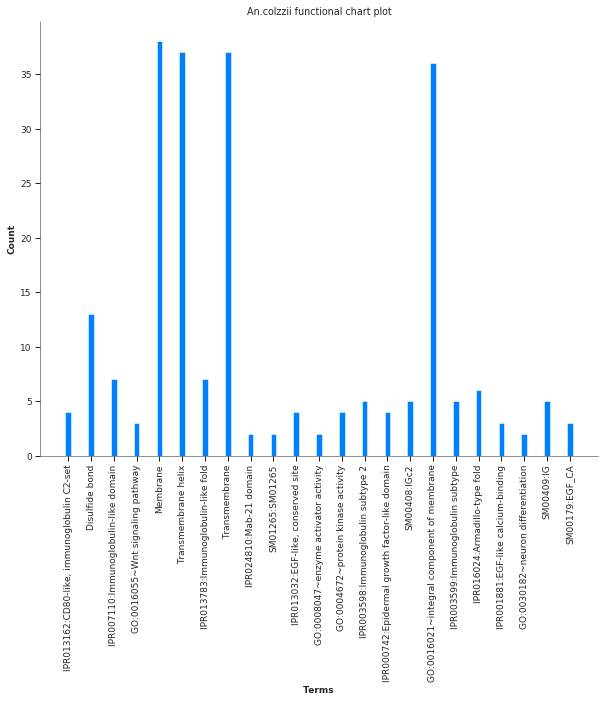

In [96]:
arr1 = np.asarray(david_chart["Count"])
arr2 = np.asarray(david_chart["Term"])
fig, ax = plt.subplots(figsize=(10, 8))
    

barWidth = 0.25

r1 = np.arange(len(arr1))


plt.bar(r1, arr1, color='#0080ff', width=barWidth, edgecolor='white')

plt.xlabel('Terms', fontweight='bold')
plt.xticks([r for r in range(len(r1))], arr2, rotation=90)
plt.ylabel('Count', fontweight='bold')

sns.despine()
ax.set_title('An.colzzii functional chart plot')
plt.show()

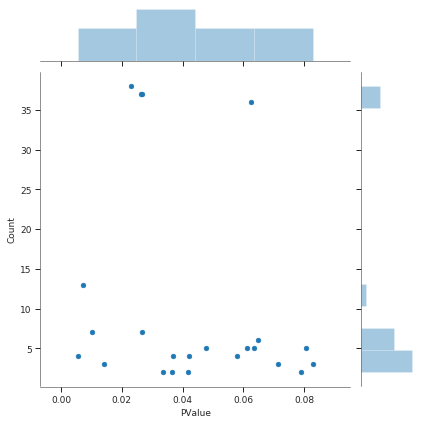

In [97]:
sns.jointplot(x="PValue", y="Count", data=david_chart);

In [101]:
kegg_129 = pd.read_csv('data/129_KEGG_aga_functional_classification.tsv', delimiter='\t')
kegg_129

,Genes,Process~name,num_of_Genes,gene_group,percentage%,P-value,Benjamini and Hochberg (FDR),Hommel singlewise process,Bonferroni single-step process,Hommel singlewise process,Hochberg step-up process,Benjamini and Yekutieli
0,AgaP_AGAP001050;,aga00532~Glycosaminoglycan_biosynthesis,1,7,14.285714,0.996507,1,1,1,1.0,1,1
1,AgaP_AGAP001047;,aga00562~Inositol_phosphate_metabolism,1,39,2.564103,1.000000,1,1,1,1.0,1,1
2,AgaP_AGAP000973;,aga00600~Sphingolipid_metabolism,1,25,4.000000,1.000000,1,1,1,1.0,1,1
3,AgaP_AGAP013093;,aga00970~Aminoacyl-tRNA_biosynthesis,1,65,1.538462,1.000000,1,1,1,1.0,1,1
4,AgaP_AGAP001038; AgaP_AGAP001039;,aga00981~Insect_hormone_biosynthesis,2,25,8.000000,1.000000,1,1,1,1.0,1,1
5,AgaP_AGAP000973; AgaP_AGAP001047; AgaP_AGAP001050; AgaP_AGAP013093;,aga01100~Metabolic_pathways,4,896,0.446429,NaN,0,0,0,NaN,0,0
6,AgaP_AGAP000950;,aga03010~Ribosome,1,133,0.751880,NaN,0,0,0,NaN,0,0
7,AgaP_AGAP010297;,aga03013~RNA_transport,1,121,0.826446,1.000000,1,1,1,1.0,1,1
8,AgaP_AGAP001045;,aga03020~RNA_polymerase,1,26,3.846154,1.000000,1,1,1,1.0,1,1
9,AgaP_AGAP010313;,aga03460~Fanconi_anemia_pathway,1,27,3.703704,1.000000,1,1,1,1.0,1,1


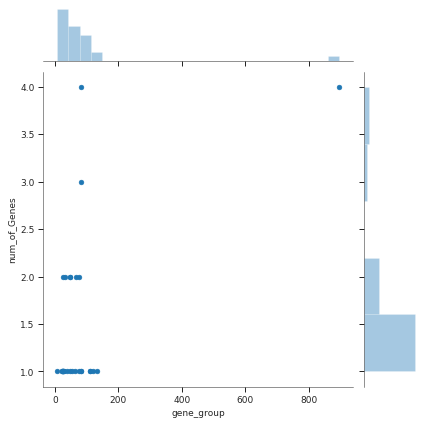

In [102]:
sns.jointplot(x="gene_group", y="num_of_Genes", data=kegg_129);

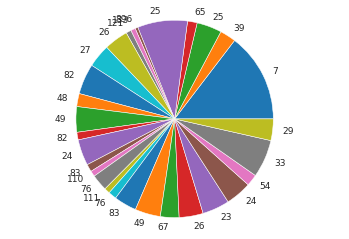

In [103]:
labels = np.asarray(kegg_129["gene_group"])
sizes = np.asarray(kegg_129["percentage%"])
 # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

- <b>aga04013 MAPK signaling pathway</b>,

<b>Class: Environmental Information Processing; Signal transduction</b>
 	
The mitogen-activated protein kinase (MAPK) signaling cascades that are highly conserved from yeast to mammals use protein phosphorylation to convey signals intracellularly, and play a crucial role in mitosis, apoptosis, motility and metabolism. In fruit fly, three major classes of MAPK pathways have been distinguished with little or no redundancy, including extracellular signal-regulated kinase (ERK) / Rolled, c-Jun N-terminal kinase (JNK) / Bsk, and p38 kinase. Signals from growth factors or mitogens are dominantly transduced by the ERK pathway, whereas the JNK and p38 pathways are activated mostly by environmental stresses. The MAPK signaling cascades are typically linked to regulation of gene expression, because transcription factors are often the targets of regulatory phosphorylation events. 

https://www.genome.jp/dbget-bin/www_bget?aga04013

- <b>aga04150 mTOR signaling pathway</b>,

<b>Class:Environmental Information Processing; Signal transduction</b>
 	
The mammalian (mechanistic) target of rapamycin (mTOR) is a highly conserved serine/threonine protein kinase, which exists in two complexes termed mTOR complex 1 (mTORC1) and 2 (mTORC2). mTORC1 contains mTOR, Raptor, PRAS40, Deptor, mLST8, Tel2 and Tti1. mTORC1 is activated by the presence of growth factors, amino acids, energy status, stress and oxygen levels to regulate several biological processes, including lipid metabolism, autophagy, protein synthesis and ribosome biogenesis. On the other hand, mTORC2, which consists of mTOR, mSin1, Rictor, Protor, Deptor, mLST8, Tel2 and Tti1, responds to growth factors and controls cytoskeletal organization, metabolism and survival.

https://www.genome.jp/dbget-bin/www_bget?aga04150

- <b>aga04310 Wnt signaling pathway</b>,

<b>Class: Environmental Information Processing; Signal transduction</b>
 	
Wnt proteins are secreted morphogens that are required for basic developmental processes, such as cell-fate specification, progenitor-cell proliferation and the control of asymmetric cell division, in many different species and organs. There are at least three different Wnt pathways: the canonical pathway, the planar cell polarity (PCP) pathway and the Wnt/Ca2+ pathway. In the canonical Wnt pathway, the major effect of Wnt ligand binding to its receptor is the stabilization of cytoplasmic beta-catenin through inhibition of the bea-catenin degradation complex. Beta-catenin is then free to enter the nucleus and activate Wnt-regulated genes through its interaction with TCF (T-cell factor) family transcription factors and concomitant recruitment of coactivators. Planar cell polarity (PCP) signaling leads to the activation of the small GTPases RHOA (RAS homologue gene-family member A) and RAC1, which activate the stress kinase JNK (Jun N-terminal kinase) and ROCK (RHO-associated coiled-coil-containing protein kinase 1) and leads to remodelling of the cytoskeleton and changes in cell adhesion and motility. WNT-Ca2+ signalling is mediated through G proteins and phospholipases and leads to transient increases in cytoplasmic free calcium that subsequently activate the kinase PKC (protein kinase C) and CAMKII (calcium calmodulin mediated kinase II) and the phosphatase calcineurin.

https://www.genome.jp/dbget-bin/www_bget?pathway+aga04310